讀取資料

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
data=pd.read_csv('/content/drive/MyDrive/守燦_碩士論文實作/假新聞1/KaggleFN_EDA.csv')

Mounted at /content/drive


自然語言處理與GloVe模型建立

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


讀取資料集完成


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


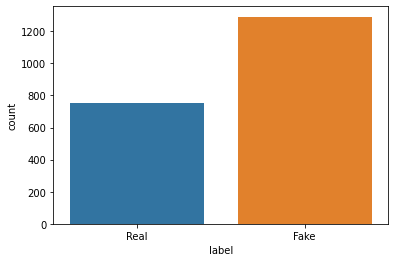

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


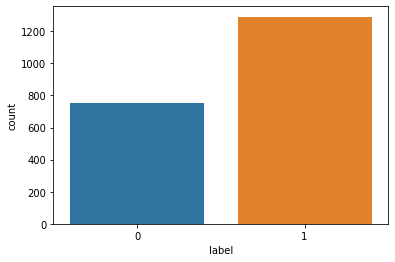

0    print they should pay all the back all the mon...
1    why did attorney general loretta lynch plead t...
2    red state   fox news sunday reported this morn...
3    email kayla mueller was a prisoner and torture...
4    email healthcare reform to make america great ...
Name: text, dtype: object
字詞正則化-完成
0    print they should pay all the back all the mon...
1    why did attorney general loretta lynch plead t...
2    red state   fox news sunday reported this morn...
3    email kayla mueller was a prisoner and torture...
4    email healthcare reform to make america great ...
Name: text, dtype: object
轉換所有字母為小寫-完成
0    [print, they, should, pay, all, the, back, all...
1    [why, did, attorney, general, loretta, lynch, ...
2    [red, state, fox, news, sunday, reported, this...
3    [email, kayla, mueller, was, a, prisoner, and,...
4    [email, healthcare, reform, to, make, america,...
Name: text, dtype: object
斷詞-完成
0    [print, pay, back, money, plus, interest, enti...
1    [attorney

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


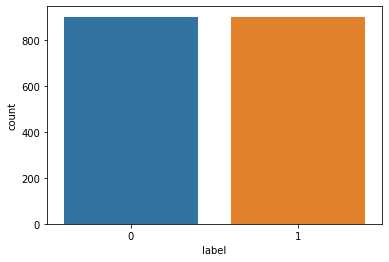

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


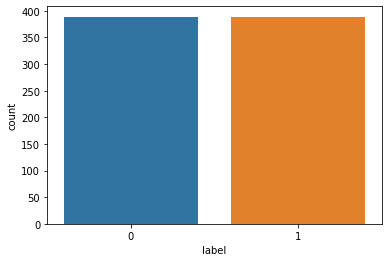

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


Embedding Matrix: 
 [[-0.08076441  0.98189977 -0.26570229 ... -0.13546749  0.59010329
   0.18767235]
 [-0.15730999 -0.75502998  0.36844999 ... -0.54136997  0.67817003
  -0.17251   ]
 [-0.38578001  0.27089     0.99612999 ...  0.41607001  0.33149999
   0.54668999]
 ...
 [-0.16833    -0.040097    0.090877   ...  0.09708    -0.49950999
   0.0074246 ]
 [-0.089059    0.24823999  0.37761    ... -0.078887    0.26931
  -0.69929999]
 [-0.42976999  0.0084318   0.53675002 ...  0.39166    -0.41466999
  -0.50554001]]
Embedding Matrix size:  (10000, 100)
建立GloVe預訓練模型-完成


In [2]:
#套件載入
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from tensorflow.keras.preprocessing import text,sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Embedding,LSTM,Bidirectional,Dense
#讀取資料集
#data=pd.read_csv('news1_eda.csv')
print("讀取資料集完成")
#觀查label欄位資料平衡的狀況
sns.countplot(data['label'])
plt.show()
#label欄位資料轉換(fake:1,true:0)
data["label"]=data.label.map({'Real':0,'Fake':1})
sns.countplot(data['label'])
plt.show()
#自然語言處理-字詞正則化
def irrelevant(text):
    return re.sub('[^a-zA-Z0-9]',' ',text)
data['text']=data['text'].apply(irrelevant)
print(data['text'].head())
print("字詞正則化-完成")
#自然語言處理-轉換所有字母為小寫
def lowering(text):
    return str(text).lower()
data['text']=data['text'].apply(lowering)
print(data['text'].head())
print("轉換所有字母為小寫-完成")
#自然語言處理-斷詞
def token(text):
    return word_tokenize(text)
data['text']=data['text'].apply(token)
print(data['text'].head())
print('斷詞-完成')
#自然語言處理-移除停用字
stopwords=set(stopwords.words('english'))
def stop_words(text):
    return [item for item in text if item not in stopwords]
data['text']=data['text'].apply(stop_words)
print(data['text'].head())
print("移除停用字-完成")
#定義X與Y
y=data["label"] #Fake或True
x=data['text'] #內文
#切割資料集
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)
print("切割資料集-完成")
#自然語言處理-標註向量與填充文字(Tokenization,Padding):用向量表示每個詞彙，以利後續GloVe模型建立。
max_len=300
tokenizer=text.Tokenizer(num_words=max_len) #標註內文的限制為內文最多300字，若少於300字則進行填充並截斷長字
tokenizer.fit_on_texts(x_train) #將內文所有詞彙的向量映射保存在Glove分詞器的word_index屬性中
tokenized_train=tokenizer.texts_to_sequences(x_train) #標註訓練集內文
x_train=sequence.pad_sequences(tokenized_train,maxlen=max_len) #填充訓練集內文
tokenized_test=tokenizer.texts_to_sequences(x_test) #標註測試集內文
x_test=sequence.pad_sequences(tokenized_test,maxlen=max_len) #填充測試集內文
print("標註與填充文字-完成")
#解決資料不平衡(SMOTE)
x_train,y_train=SMOTE().fit_resample(x_train,y_train)
x_test,y_test=SMOTE().fit_resample(x_test,y_test)
#觀察SMOTE平衡後的資料分佈
sns.countplot(y_train)
plt.show()
sns.countplot(y_test)
plt.show()
#建立GloVe預訓練模型
max_features=10000 #詞彙共現矩陣的最大特徵為10000
embedding_file="/content/drive/MyDrive/守燦_碩士論文實作/預訓練資源檔/glove.6B.100d.txt" #GloVe預訓練模型的檔案
def get_coeffs(word,*arr): #定義文字轉換為數字的運作方法
    return word,np.asarray(arr,dtype='float32')
embedding_index=dict(get_coeffs(*o.rstrip().rsplit(' ')) for o in open(embedding_file,encoding='utf-8')) #利用get_coeffs方法載入預訓練檔案，得到預訓練檔案的數值並儲存在字典中
embeds=np.stack(embedding_index.values()) #將字典裡的數值嵌入至新的序列
emb_mean,emb_std=embeds.mean(),embeds.std() #計算嵌入的平均數與標準差
embed_size=embeds.shape[1] #計算嵌入值序列的資料維度
word_index=tokenizer.word_index #Glove模型的分詞器
nb_words=min(max_features,len(word_index)) #定義最小特徵與最小維度需與GloVe分詞器一致
embedding_matrix=np.random.normal(emb_mean,emb_std,(nb_words,embed_size)) #詞彙共現性矩陣是經由嵌入的平均數、標準差、Glove分詞器三者的常態擬和求得
for word, i in word_index.items():#進行文字轉換為文字向量，完成預訓練，求出詞彙共現性矩陣
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
print("Embedding Matrix: \n",embedding_matrix)
print("Embedding Matrix size: ",embedding_matrix.shape)
print("建立GloVe預訓練模型-完成")

嵌入Glove至BiLSTM模型訓練

In [3]:
#定義BiLSTM模型參數
batch_size=128
epochs=20
embed_size=100
#建立BiLSTM模型
model=Sequential()
model.add(Embedding(max_features,output_dim=embed_size,weights=[embedding_matrix],input_length=max_len,trainable=False))
model.add(Bidirectional(LSTM(64,return_sequences=True)))
model.add(Bidirectional(LSTM(32,return_sequences=False)))
model.add(Dense(16,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
print(model.summary())
print("BiLSTM模型建立-完成")
#訓練BiLSTM模型
history=model.fit(x_train,y_train,batch_size=batch_size,validation_data=(x_test,y_test),epochs=epochs)
print("BiLSTM模型訓練-完成")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 bidirectional (Bidirectiona  (None, 300, 128)         84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,126,753
Trainable params: 126,753
Non-tr

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


None
BiLSTM模型建立-完成
Epoch 1/20
15/15 [==============================] - 18s 165ms/step - loss: 0.6822 - accuracy: 0.5416 - val_loss: 0.6635 - val_accuracy: 0.6118
Epoch 2/20
15/15 [==============================] - 1s 59ms/step - loss: 0.6557 - accuracy: 0.6037 - val_loss: 0.6391 - val_accuracy: 0.6272
Epoch 3/20
15/15 [==============================] - 1s 58ms/step - loss: 0.6289 - accuracy: 0.6408 - val_loss: 0.6291 - val_accuracy: 0.6311
Epoch 4/20
15/15 [==============================] - 1s 57ms/step - loss: 0.6428 - accuracy: 0.6297 - val_loss: 0.6440 - val_accuracy: 0.6208
Epoch 5/20
15/15 [==============================] - 1s 56ms/step - loss: 0.6077 - accuracy: 0.6680 - val_loss: 0.6077 - val_accuracy: 0.6504
Epoch 6/20
15/15 [==============================] - 1s 59ms/step - loss: 0.5767 - accuracy: 0.6874 - val_loss: 0.5995 - val_accuracy: 0.6799
Epoch 7/20
15/15 [==============================] - 1s 56ms/step - loss: 0.5572 - accuracy: 0.7007 - val_loss: 0.5920 - val_accuracy:

模型績效評估(準確度、損失函數、分類報告、混淆矩陣)

In [4]:
#準確度評估
print("訓練集的模型準確度: " ,model.evaluate(x_train,y_train)[1]*100 , "%")
print("測試集的模型準確度: " ,model.evaluate(x_test,y_test)[1]*100 , "%")

57/57 [==============================] - 1s 19ms/step - loss: 0.3090 - accuracy: 0.8631
訓練集的模型準確度:  86.30820512771606 %
25/25 [==============================] - 0s 18ms/step - loss: 0.6749 - accuracy: 0.7134
測試集的模型準確度:  71.33675813674927 %


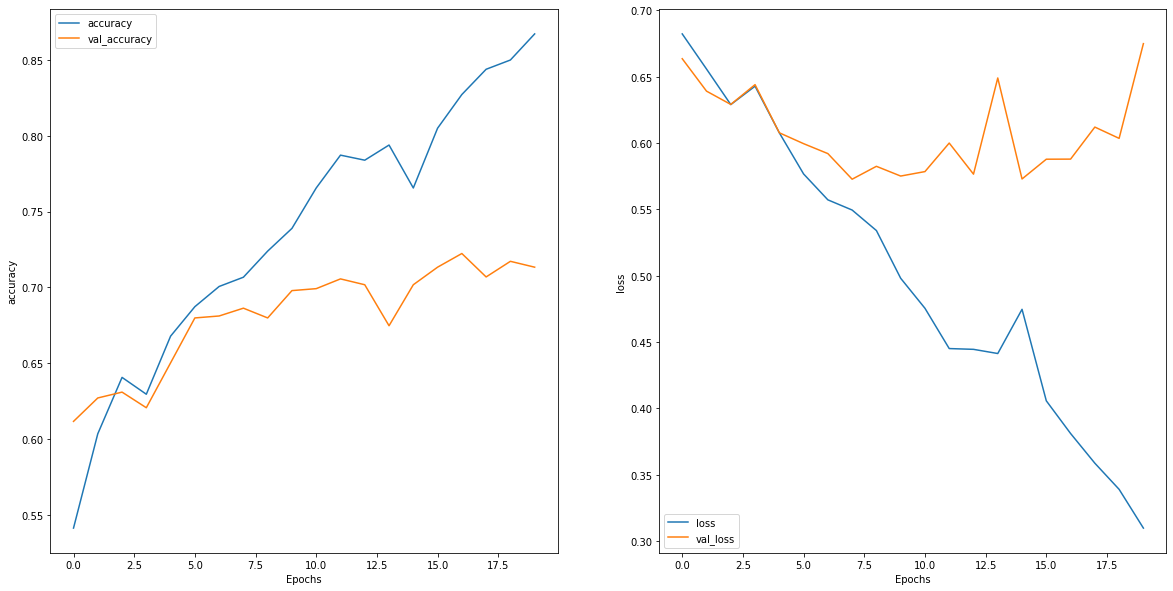

In [5]:
#繪製準確度變化與損失函數圖
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric],'')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric,'val_'+metric])
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plot_graphs(history,'accuracy')
plt.subplot(1,2,2)
plot_graphs(history,'loss')

In [6]:
#分類報告
prediction=(model.predict(x_test)>0.5).astype("int32")
print("分類報告: ",classification_report(y_test,prediction,digits=4))

分類報告:                precision    recall  f1-score   support

           0     0.7627    0.6195    0.6837       389
           1     0.6797    0.8072    0.7380       389

    accuracy                         0.7134       778
   macro avg     0.7212    0.7134    0.7108       778
weighted avg     0.7212    0.7134    0.7108       778



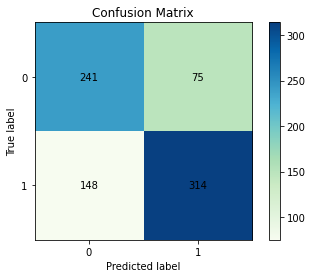

In [7]:
#繪製混淆矩陣
def plot_confusion_matrix(confusion_mat):
    plt.imshow(confusion_mat,interpolation='nearest',cmap=plt.cm.GnBu)
    plt.colorbar()
    for x in range(len(confusion_mat)):
        for y in range(len(confusion_mat)):
            plt.annotate(confusion_mat[x, y], xy=(x, y),horizontalalignment='center',verticalalignment='center')
    plt.title('Confusion Matrix')    
    plt.ylabel('True label')         
    plt.xlabel('Predicted label')     
    tick_marks = np.arange(2)
    plt.xticks(tick_marks,tick_marks)
    plt.yticks(tick_marks,tick_marks)
    plt.show()
confusion_mat=metrics.confusion_matrix(y_test,prediction,labels=None,sample_weight=None)
plot_confusion_matrix(confusion_mat)